# Time Series Mini Project

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import username, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
np.random.seed(0)

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

# Acquire

In [2]:
def wrangle_temp_by_state():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run 
    the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'GlobalLandTemperaturesByState.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
        
    return df

In [3]:
df = wrangle_temp_by_state()

In [4]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,State,Country
0,1855-05-01,25.544,1.171,Acre,Brazil
1,1855-06-01,24.228,1.103,Acre,Brazil
2,1855-07-01,24.371,1.044,Acre,Brazil
3,1855-08-01,25.427,1.073,Acre,Brazil
4,1855-09-01,25.675,1.014,Acre,Brazil


In [5]:
df.shape

(645675, 5)

# Prep

In [6]:
#change data type on Date
df.dt = df.dt.astype('datetime64[ns]')

In [7]:
#set the index to Date
df = df.set_index('dt').sort_index()

In [8]:
# check head
df.head()

,AverageTemperature,AverageTemperatureUncertainty,State,Country
dt,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [9]:
#rename columns
df = df.rename(columns={'AverageTemperature':'average_temp', 
                        'AverageTemperatureUncertainty':'average_temp_uncertainty', 
                        'State':'state','Country':'country'})
    

In [10]:
# check head
df.head()

,average_temp,average_temp_uncertainty,state,country
dt,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [11]:
# rename index
df.index.names = ['date']

In [12]:
# check head
df.head()

,average_temp,average_temp_uncertainty,state,country
date,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada
1743-11-01,0.753,2.817,Michigan,United States
1743-11-01,0.665,2.208,Prince Edward Island,Canada
1743-11-01,-0.526,2.304,Pskov,Russia
1743-11-01,1.891,1.718,Massachusetts,United States


In [13]:
# check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645675 entries, 1743-11-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   average_temp              620027 non-null  float64
 1   average_temp_uncertainty  620027 non-null  float64
 2   state                     645675 non-null  object 
 3   country                   645675 non-null  object 
dtypes: float64(2), object(2)
memory usage: 24.6+ MB


In [14]:
# fill them
df = df.fillna(0)

In [15]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 645675 entries, 1743-11-01 to 2013-09-01
Data columns (total 4 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   average_temp              645675 non-null  float64
 1   average_temp_uncertainty  645675 non-null  float64
 2   state                     645675 non-null  object 
 3   country                   645675 non-null  object 
dtypes: float64(2), object(2)
memory usage: 24.6+ MB


In [16]:
#create new colum for month
df['month'] = df.index.month_name()
#create new colum for weekday
df['day_of_week'] = df.index.day_name()
#create new column for year
df['year'] = df.index.year

In [17]:
# check final clean up
df.head()

,average_temp,average_temp_uncertainty,state,country,month,day_of_week,year
date,,,,,,,
1743-11-01,1.909,2.033,Nova Scotia,Canada,November,Friday,1743
1743-11-01,0.753,2.817,Michigan,United States,November,Friday,1743
1743-11-01,0.665,2.208,Prince Edward Island,Canada,November,Friday,1743
1743-11-01,-0.526,2.304,Pskov,Russia,November,Friday,1743
1743-11-01,1.891,1.718,Massachusetts,United States,November,Friday,1743


In [18]:
print('Date Range:', df.index.min(), 'to', df.index.max())
print('Shape:', df.shape)

Date Range: 1743-11-01 00:00:00 to 2013-09-01 00:00:00
Shape: (645675, 7)


In [155]:
#display maximum timestamp allowed 
print(pd.Timestamp.max)

2262-04-11 23:47:16.854775807


In [161]:
pd.set_option('display.max_rows', None)
df.index.value_counts(ascending=False)

2013-09-01    241
1925-11-01    241
1926-01-01    241
1926-02-01    241
1926-03-01    241
1926-04-01    241
1926-05-01    241
1926-06-01    241
1926-07-01    241
1926-08-01    241
1926-09-01    241
1926-10-01    241
1926-11-01    241
1926-12-01    241
1927-01-01    241
1927-02-01    241
1927-03-01    241
1927-04-01    241
1927-05-01    241
1927-06-01    241
1927-07-01    241
1927-08-01    241
1927-09-01    241
1925-12-01    241
1925-10-01    241
1915-08-01    241
1925-09-01    241
1923-12-01    241
1924-01-01    241
1924-02-01    241
1924-03-01    241
1924-04-01    241
1924-05-01    241
1924-06-01    241
1924-07-01    241
1924-08-01    241
1924-09-01    241
1924-10-01    241
1924-11-01    241
1924-12-01    241
1925-01-01    241
1925-02-01    241
1925-03-01    241
1925-04-01    241
1925-05-01    241
1925-06-01    241
1925-07-01    241
1925-08-01    241
1927-10-01    241
1927-11-01    241
1927-12-01    241
1928-01-01    241
1930-02-01    241
1930-03-01    241
1930-04-01    241
1930-05-01

# Split 

In [19]:
train_len = int(0.6 * len(df))
val_test_split = int(0.8 * len(df))
train_len, val_test_split

(387405, 516540)

In [20]:
train = df.iloc[:train_len]
val = df.iloc[train_len:val_test_split]
test = df.iloc[val_test_split:]
train.shape, val.shape, test.shape

((387405, 7), (129135, 7), (129135, 7))

# Explore

In [21]:
def plot_distributions(df):
    for col in list(df.columns):
        plt.figure()
        sns.histplot(df[col])
        plt.title('Distribution of {}'.format(col))

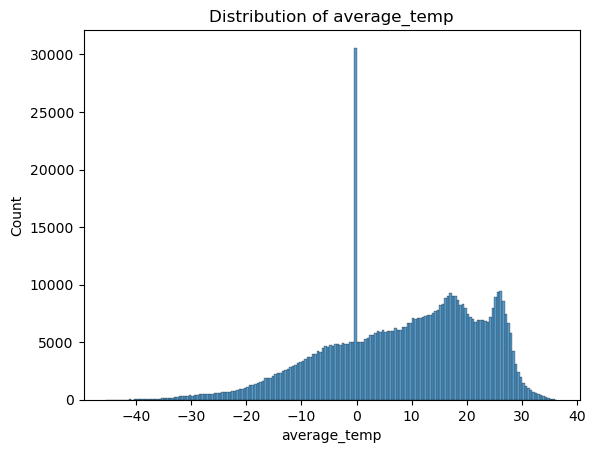

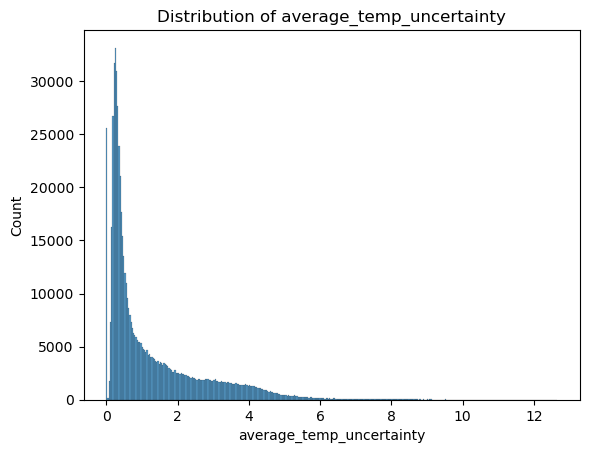

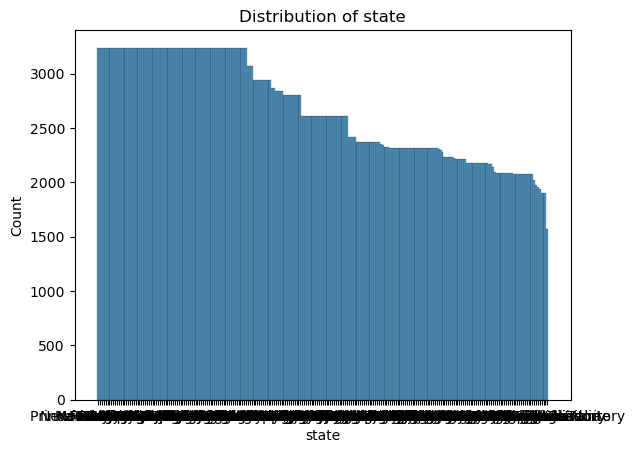

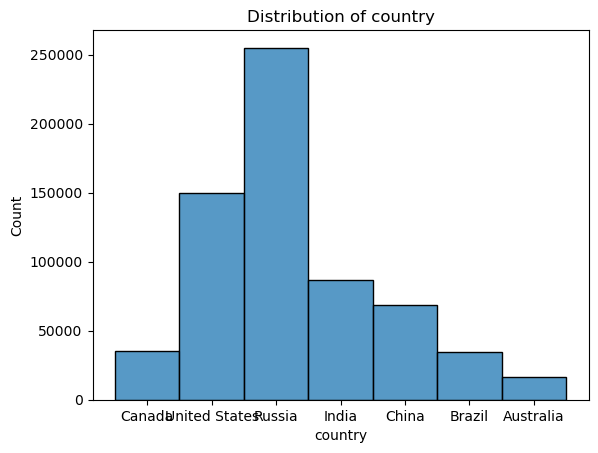

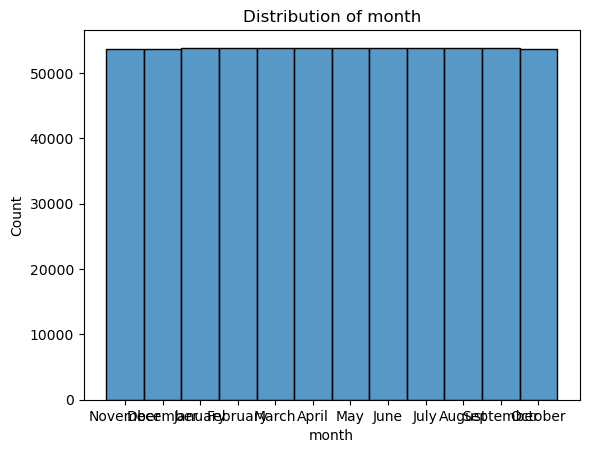

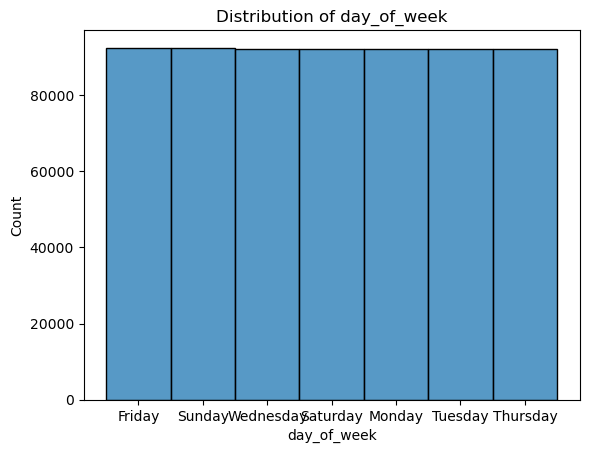

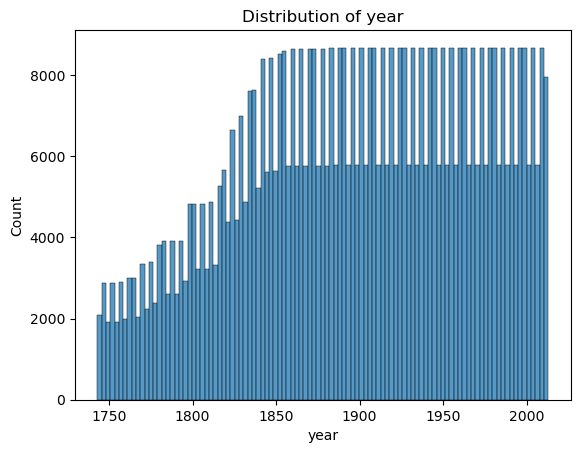

In [22]:
plot_distributions(df)

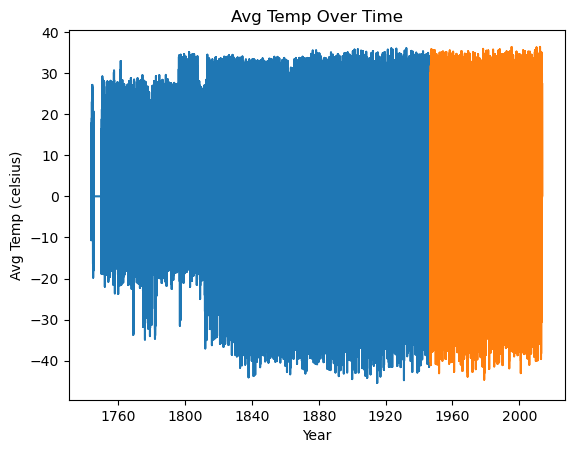

In [23]:
#plot train with target of average temp
#use percentage-based data split
train_size = .70

#n is the entire number of entries in the dataframe
n = df.shape[0]

#look at what n is (total entries in the df)
n
#set the test size to 70% * total number of entries 
test_start_index = round(train_size * n)

#take a look (70% of entire df)
test_start_index
#everything up (not including) to the test_start_index
perc_train = df[:test_start_index]

#everything from the test_start_index to the end
perc_test = df[test_start_index:] 
plt.plot(perc_train.index, perc_train.average_temp)
#plot test with target of sale amount
plt.plot(perc_test.index, perc_test.average_temp)

plt.title('Avg Temp Over Time')

plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')

None

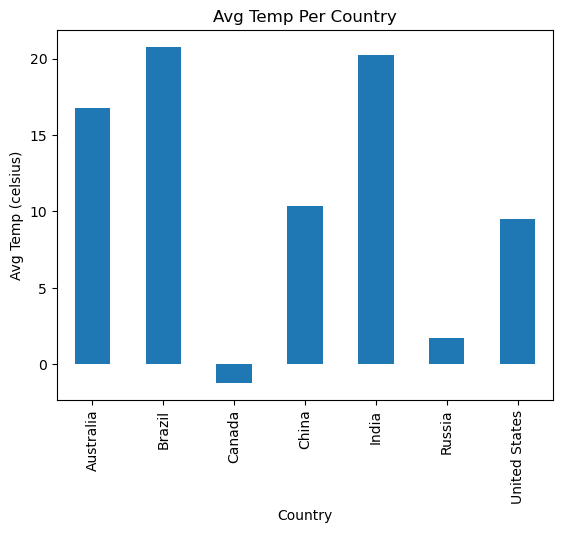

In [24]:
train.groupby('country')['average_temp'].mean().plot.bar()
plt.title('Avg Temp Per Country')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Country')
plt.show()

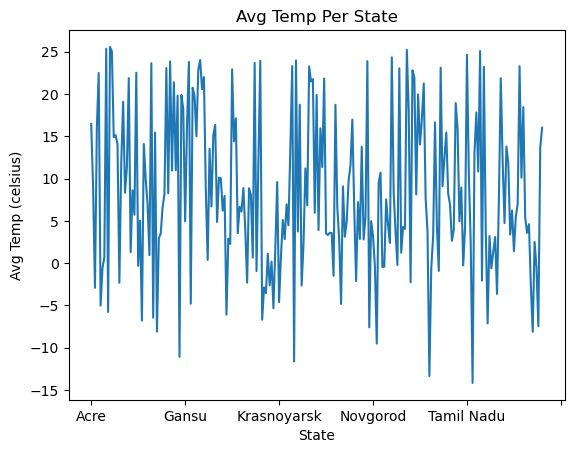

In [25]:
train.groupby('state')['average_temp'].mean().plot()
plt.title('Avg Temp Per State')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('State')
plt.show()

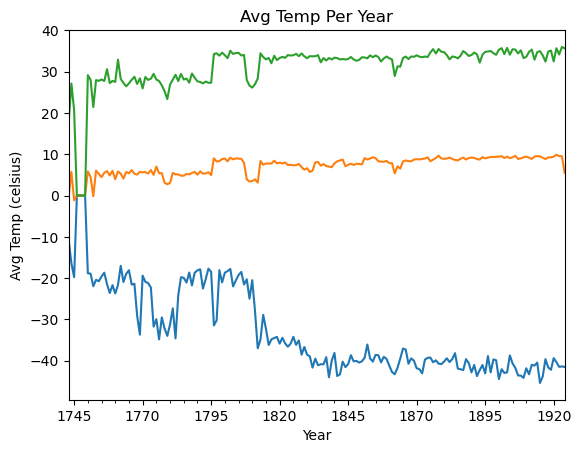

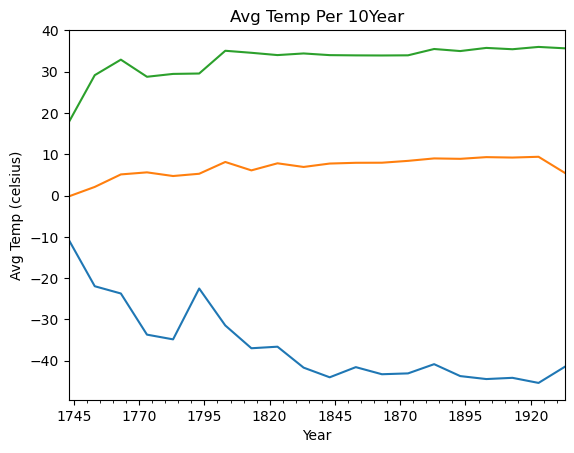

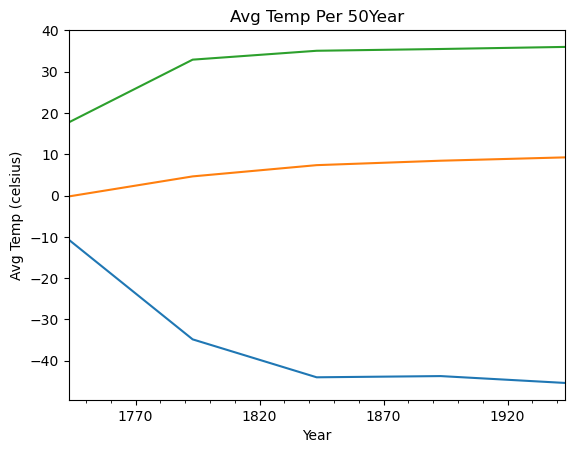

In [26]:
train.resample('Y').min()['average_temp'].plot()
train.resample('Y').mean()['average_temp'].plot()
train.resample('Y').max()['average_temp'].plot()
plt.title('Avg Temp Per Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()

train.resample('10Y').min()['average_temp'].plot()
train.resample('10Y').mean()['average_temp'].plot()
train.resample('10Y').max()['average_temp'].plot()
plt.title('Avg Temp Per 10Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()

train.resample('50Y').min()['average_temp'].plot()
train.resample('50Y').mean()['average_temp'].plot()
train.resample('50Y').max()['average_temp'].plot()
plt.title('Avg Temp Per 50Year')
plt.ylabel('Avg Temp (celsius)')
plt.xlabel('Year')
plt.show()


# Model

In [27]:
df_resampled = train.resample('Y')[['average_temp']].sum()
df_resampled.head()

,average_temp
date,
1743-12-31,-36.451
1744-12-31,5500.493
1745-12-31,-1116.090
1746-12-31,0.000
1747-12-31,0.000


In [28]:
df_resampled.shape

(182, 1)

In [29]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

91

In [30]:
# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

55

In [31]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

36

In [32]:
len(df_resampled) == train_size + validate_size + test_size

True

In [33]:
# validate will go from 24 to 24 + 14
validate_end_index = train_size + validate_size
validate_end_index

146

In [34]:
# train will go from 0 to 23
train = df_resampled[:train_size]

In [35]:
train.tail()

,average_temp
date,
1829-12-31,14649.339
1830-12-31,15627.183
1831-12-31,13463.062
1832-12-31,15147.688
1833-12-31,20352.810


In [36]:
# validate will go from 24 to 37
validate = df_resampled[train_size:validate_end_index]

In [37]:
validate.head()

,average_temp
date,
1834-12-31,20534.774
1835-12-31,18359.134
1836-12-31,19335.577
1837-12-31,18152.401
1838-12-31,17839.463


In [38]:
validate.tail()

,average_temp
date,
1884-12-31,24924.633
1885-12-31,24578.544
1886-12-31,25724.845
1887-12-31,26541.468
1888-12-31,25245.192


In [39]:
# test will include 1459 to the end
test = df_resampled[validate_end_index:]

In [40]:
test.head()

,average_temp
date,
1889-12-31,26230.149
1890-12-31,26643.373
1891-12-31,26330.038
1892-12-31,25560.800
1893-12-31,25171.210


In [41]:
train.shape[0], validate.shape[0], test.shape[0]

(91, 55, 36)

In [42]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(df_resampled)

True

In [43]:
print(df_resampled.head(1) == train.head(1))

            average_temp
date                    
1743-12-31          True


In [44]:
pd.concat([test.tail(1), df_resampled.tail(1)])

,average_temp
date,
1924-12-31,7089.654
1924-12-31,7089.654


In [45]:
train.columns

Index(['average_temp'], dtype='object')

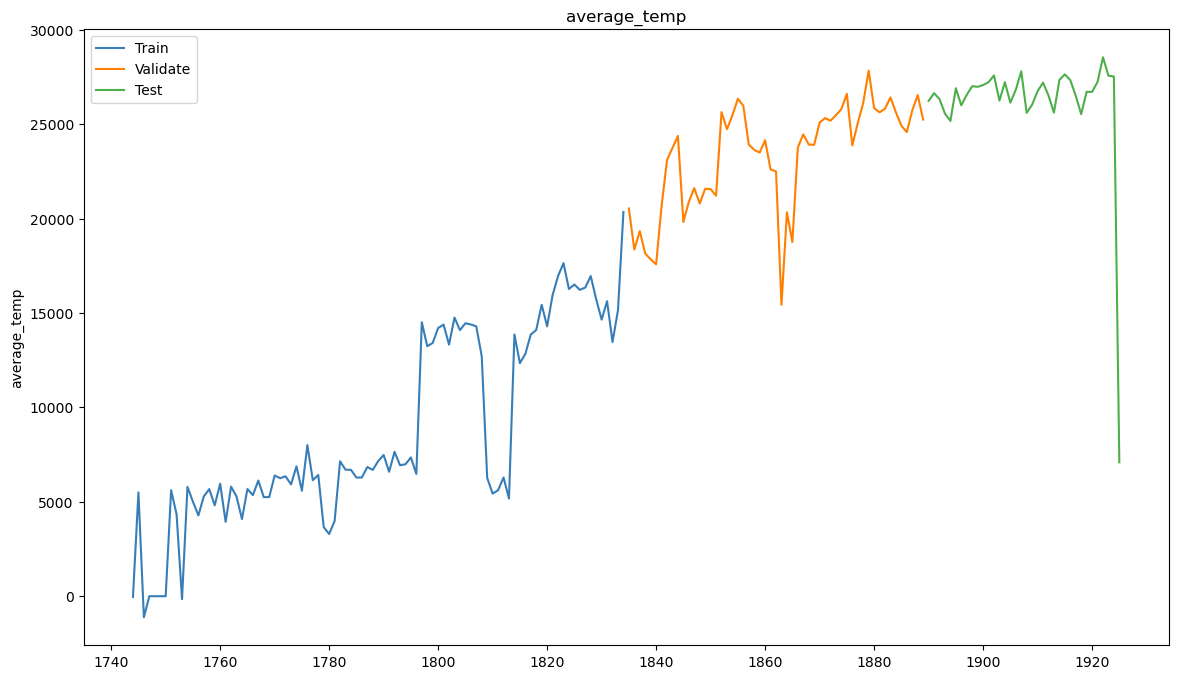

In [46]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col], color='#377eb8', label = 'Train')
    plt.plot(validate[col], color='#ff7f00', label = 'Validate')
    plt.plot(test[col], color='#4daf4a', label = 'Test')
    plt.legend()
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [47]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [48]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1, color='#377eb8')
    plt.plot(validate[target_var], label='Validate', linewidth=1, color='#ff7f00')
    plt.plot(yhat_df[target_var], label='yhat', linewidth=2, color='#a65628')
    plt.legend()
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [49]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [50]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [51]:
train['average_temp'][-1:][0]

20352.81

In [52]:
# take the last item of sales total and assign to variable
last_temp = train['average_temp'][-1:][0]

In [53]:
yhat_df = pd.DataFrame(
    {'average_temp': [last_temp],
     },
    index=validate.index)

yhat_df.head()

,average_temp
date,
1834-12-31,20352.81
1835-12-31,20352.81
1836-12-31,20352.81
1837-12-31,20352.81
1838-12-31,20352.81


In [54]:
yhat_df.describe()

,average_temp
count,5.500000e+01
mean,2.035281e+04
std,2.937207e-11
min,2.035281e+04
25%,2.035281e+04
50%,2.035281e+04
75%,2.035281e+04
max,2.035281e+04


average_temp -- RMSE: 4082


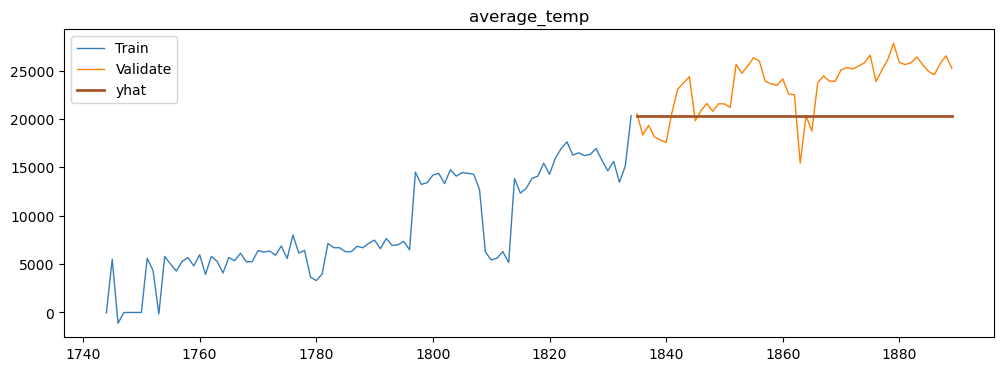

In [55]:
for col in train.columns:
    plot_and_eval(col)

In [56]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,4082.0


In [57]:
# compute simple average of sales_total (from train data)
avg_temp = round(train['average_temp'].mean(), 2)
avg_temp

8692.14

In [65]:
def make_baseline_predictions(temp_predictions=None):
    yhat_df = pd.DataFrame({'average_temp': [temp_predictions],
                           },
                          index=validate.index)
    return yhat_df

In [66]:
yhat_df = make_baseline_predictions(avg_temp)

In [67]:
yhat_df.head()

,average_temp
date,
1834-12-31,8692.14
1835-12-31,8692.14
1836-12-31,8692.14
1837-12-31,8692.14
1838-12-31,8692.14


In [68]:
yhat_df.describe()

,average_temp
count,5.500000e+01
mean,8.692140e+03
std,1.101453e-11
min,8.692140e+03
25%,8.692140e+03
50%,8.692140e+03
75%,8.692140e+03
max,8.692140e+03


In [69]:
train

,average_temp
date,
1743-12-31,-36.451
1744-12-31,5500.493
1745-12-31,-1116.090
1746-12-31,0.000
1747-12-31,0.000
...,...
1829-12-31,14649.339
1830-12-31,15627.183
1831-12-31,13463.062


average_temp -- RMSE: 14899


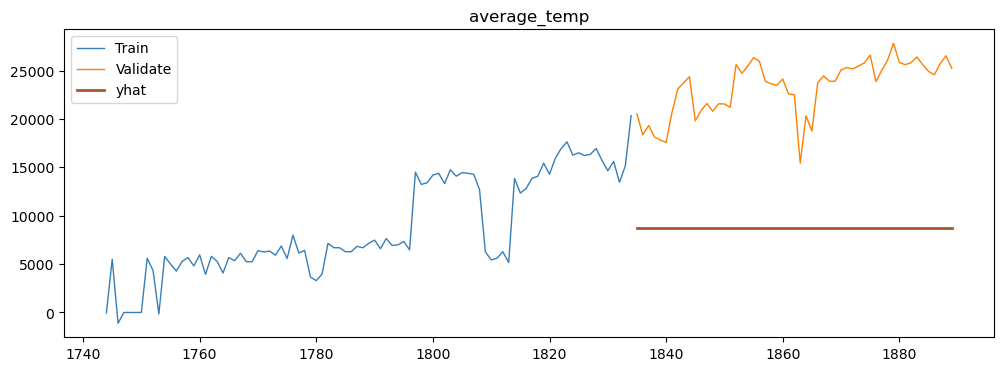

In [70]:
for col in train.columns:
    plot_and_eval(col)

In [71]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,4082.0
1,simple_average,average_temp,14899.0


In [73]:
period=30
train['average_temp'].rolling(period).mean()

date
1743-12-31             NaN
1744-12-31             NaN
1745-12-31             NaN
1746-12-31             NaN
1747-12-31             NaN
                  ...     
1829-12-31    13371.581600
1830-12-31    13412.975367
1831-12-31    13417.558367
1832-12-31    13430.549000
1833-12-31    13639.168633
Freq: A-DEC, Name: average_temp, Length: 91, dtype: float64

In [74]:
# Saving the last 30 day moving average for each column
rolling_temp = round(train['average_temp'].rolling(period).mean()[-1], 2)
print(rolling_temp)

13639.17


In [75]:
yhat_df = make_baseline_predictions(rolling_temp)
yhat_df.head()

,average_temp
date,
1834-12-31,13639.17
1835-12-31,13639.17
1836-12-31,13639.17
1837-12-31,13639.17
1838-12-31,13639.17


average_temp -- RMSE: 10083


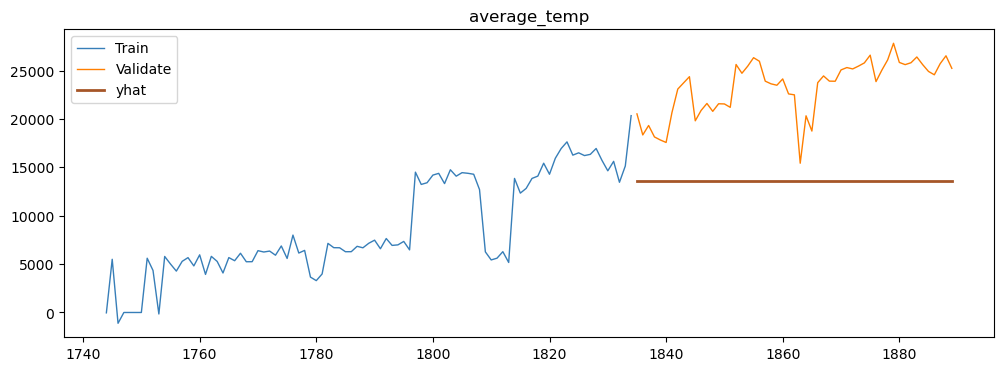

In [76]:
for col in train.columns:
    plot_and_eval(col)

In [77]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,4082.0
1,simple_average,average_temp,14899.0
2,30d_moving_avg,average_temp,10083.0


In [80]:
periods = [4, 12, 26, 52]

for p in periods: 
    rolling_temp = round(train['average_temp'].rolling(p).mean()[-1], 2)
    yhat_df = make_baseline_predictions(rolling_temp)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [81]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,4082.0
1,simple_average,average_temp,14899.0
2,30d_moving_avg,average_temp,10083.0
3,4_day_moving_avg,average_temp,7704.0
4,12_day_moving_avg,average_temp,7615.0
5,26_day_moving_avg,average_temp,10131.0
6,52_day_moving_avg,average_temp,11793.0
7,4_day_moving_avg,average_temp,7704.0
8,12_day_moving_avg,average_temp,7615.0
9,26_day_moving_avg,average_temp,10131.0


In [84]:
best_quantity_rmse = eval_df[eval_df.target_var == 'average_temp']['rmse'].min()

In [85]:
best_quantity_rmse

4082.0

In [86]:
eval_df[eval_df.rmse == best_quantity_rmse]

,model_type,target_var,rmse
0,last_observed_value,average_temp,4082.0


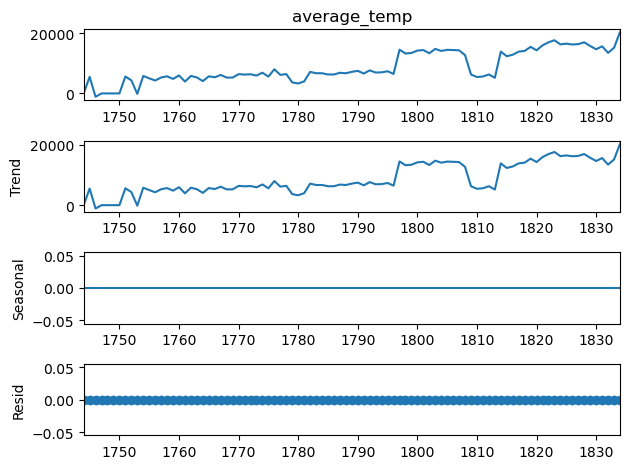

In [93]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('Y').mean()).plot()

In [94]:
col = 'average_temp' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [95]:
# fit the Holt object
model = model.fit(optimized=True)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [97]:
# predict it but also give it a starting and ending point
yhat_temp_avg = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [98]:
validate.shape

(55, 1)

In [99]:
yhat_temp_avg

1834-12-31    20362.690212
1835-12-31    21604.766455
1836-12-31    22834.421934
1837-12-31    24051.780859
1838-12-31    25256.966195
1839-12-31    26450.099677
1840-12-31    27631.301825
1841-12-31    28800.691951
1842-12-31    29958.388176
1843-12-31    31104.507438
1844-12-31    32239.165508
1845-12-31    33362.476997
1846-12-31    34474.555371
1847-12-31    35575.512962
1848-12-31    36665.460977
1849-12-31    37744.509511
1850-12-31    38812.767560
1851-12-31    39870.343029
1852-12-31    40917.342743
1853-12-31    41953.872460
1854-12-31    42980.036880
1855-12-31    43995.939655
1856-12-31    45001.683403
1857-12-31    45997.369713
1858-12-31    46983.099160
1859-12-31    47958.971313
1860-12-31    48925.084744
1861-12-31    49881.537041
1862-12-31    50828.424815
1863-12-31    51765.843711
1864-12-31    52693.888418
1865-12-31    53612.652678
1866-12-31    54522.229296
1867-12-31    55422.710147
1868-12-31    56314.186190
1869-12-31    57196.747472
1870-12-31    58070.483142
1

In [100]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [101]:
yhat_df.head()

,average_temp
date,
1834-12-31,20362.69
1835-12-31,21604.77
1836-12-31,22834.42
1837-12-31,24051.78
1838-12-31,25256.97


average_temp -- RMSE: 28719


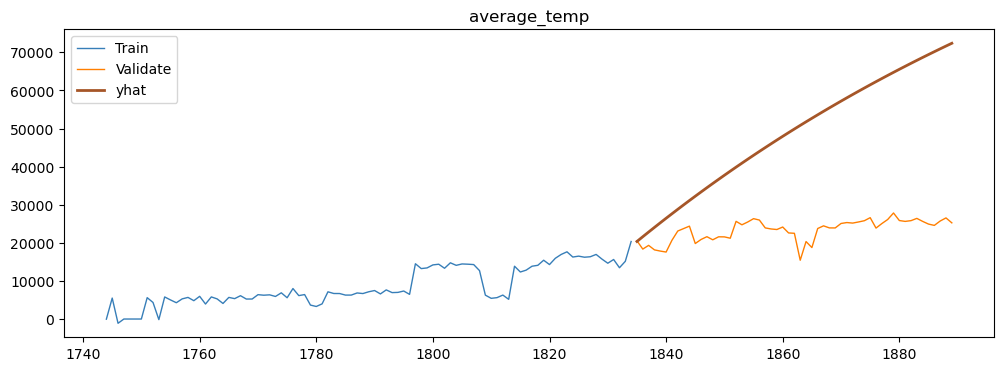

In [102]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [103]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [104]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
0,last_observed_value,average_temp,4082.0
4,12_day_moving_avg,average_temp,7615.0
8,12_day_moving_avg,average_temp,7615.0
3,4_day_moving_avg,average_temp,7704.0
7,4_day_moving_avg,average_temp,7704.0
2,30d_moving_avg,average_temp,10083.0
5,26_day_moving_avg,average_temp,10131.0
9,26_day_moving_avg,average_temp,10131.0
6,52_day_moving_avg,average_temp,11793.0
10,52_day_moving_avg,average_temp,11793.0


In [123]:
# Models for sales
hst_temp_fit1 = ExponentialSmoothing(train.average_temp, seasonal_periods=40, trend='add', seasonal='add').fit()
hst_temp_fit3 = ExponentialSmoothing(train.average_temp, seasonal_periods=40, trend='add', seasonal='add', damped=True).fit()

/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [124]:
hst_temp_fit1.params

{'smoothing_level': 0.6767857142857143,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.10100446428571427,
 'damping_trend': nan,
 'initial_level': 4428.395022499997,
 'initial_trend': 140.87308795454572,
 'initial_seasons': array([-1100.4617325, -1744.8239825, -1964.35007  , -1624.420295 ,
        -1971.8986325, -1610.555495 , -1288.9112325, -2157.246945 ,
        -1092.84417  , -1792.4436825, -1816.5339825, -1630.2057325,
        -2650.32417  ,  5229.84103  ,  3767.91193  ,  3699.920055 ,
         4205.54078  ,  4097.58293  ,  2765.66393  ,  3938.724155 ,
         -635.784195 ,   861.61748  ,   436.3444425,  1030.116705 ,
          -17.4594575,  -185.7416075,   772.925305 ,   527.3191675,
          570.775755 ,    13.7763925,   865.88468  ,  -470.467145 ,
         1889.41953  ,  -109.2268575,   -46.0021575, -3008.4797825,
        -3585.350795 , -3129.2523075,  -191.75242  ,  -848.82742  ]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [125]:
results_average_temp=pd.DataFrame({'model':['hst_quantity_fit1', 'hst_quantity_fit2', 'hst_quantity_fit3', 'hst_quantity_fit4'],
                              'SSE':[hst_temp_fit1.sse, hst_temp_fit2.sse, hst_temp_fit3.sse, hst_temp_fit4.sse]})
results_average_temp

,model,SSE
0,hst_quantity_fit1,4.245518e+08
1,hst_quantity_fit2,4.018329e+08
2,hst_quantity_fit3,4.270340e+08
3,hst_quantity_fit4,3.967561e+08


In [126]:
results_average_temp.sort_values(by='SSE')

,model,SSE
3,hst_quantity_fit4,3.967561e+08
1,hst_quantity_fit2,4.018329e+08
0,hst_quantity_fit1,4.245518e+08
2,hst_quantity_fit3,4.270340e+08


In [127]:
yhat_df = pd.DataFrame({'average_temp': hst_temp_fit1.forecast(validate.shape[0]),
                        },
                          index=validate.index)
yhat_df

,average_temp
date,
1834-12-31,18780.596157
1835-12-31,17882.161473
1836-12-31,25247.544799
1837-12-31,24460.228664
1838-12-31,24515.827307
1839-12-31,25286.967791
1840-12-31,25137.155621
1841-12-31,24335.271317
1842-12-31,25360.182015


average_temp -- RMSE: 3241


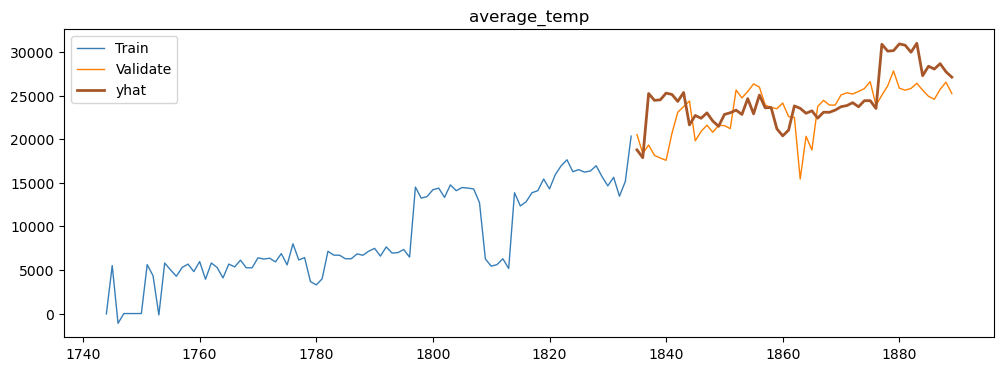

In [128]:
for col in train.columns:
    plot_and_eval(col)

In [129]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,average_temp,4082.0
1,simple_average,average_temp,14899.0
2,30d_moving_avg,average_temp,10083.0
3,4_day_moving_avg,average_temp,7704.0
4,12_day_moving_avg,average_temp,7615.0
5,26_day_moving_avg,average_temp,10131.0
6,52_day_moving_avg,average_temp,11793.0
7,4_day_moving_avg,average_temp,7704.0
8,12_day_moving_avg,average_temp,7615.0
9,26_day_moving_avg,average_temp,10131.0


In [130]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal_add_add', 
                            target_var = col)

In [131]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
12,holts_seasonal_add_add,average_temp,3241.0
0,last_observed_value,average_temp,4082.0
4,12_day_moving_avg,average_temp,7615.0
8,12_day_moving_avg,average_temp,7615.0
3,4_day_moving_avg,average_temp,7704.0
7,4_day_moving_avg,average_temp,7704.0
2,30d_moving_avg,average_temp,10083.0
5,26_day_moving_avg,average_temp,10131.0
9,26_day_moving_avg,average_temp,10131.0
6,52_day_moving_avg,average_temp,11793.0


# Test

In [132]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]

In [133]:
train.shape, validate.shape, test.shape

((91, 1), (55, 1), (36, 1))

In [143]:
yhat_df = pd.DataFrame({'average_temp': hst_temp_fit1.forecast(validate.shape[0] + test.shape[0]),
                        })
yhat_df

,average_temp
1834-12-31,18780.596157
1835-12-31,17882.161473
1836-12-31,25247.544799
1837-12-31,24460.228664
1838-12-31,24515.827307
...,...
1920-12-31,36430.901433
1921-12-31,35629.017129
1922-12-31,36653.927826
1923-12-31,32932.416674


In [144]:
validate.head(1)

,average_temp
date,
1834-12-31,20534.774


In [145]:
test.head(1)

,average_temp
date,
1889-12-31,26230.149


In [146]:
yhat_df = yhat_df['1889-12-31':]

In [148]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()

In [151]:
rmse_average_temp = sqrt(mean_squared_error(test['average_temp'], 
                                       yhat_df['average_temp']))


FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-average_temp:  6548.642693218324


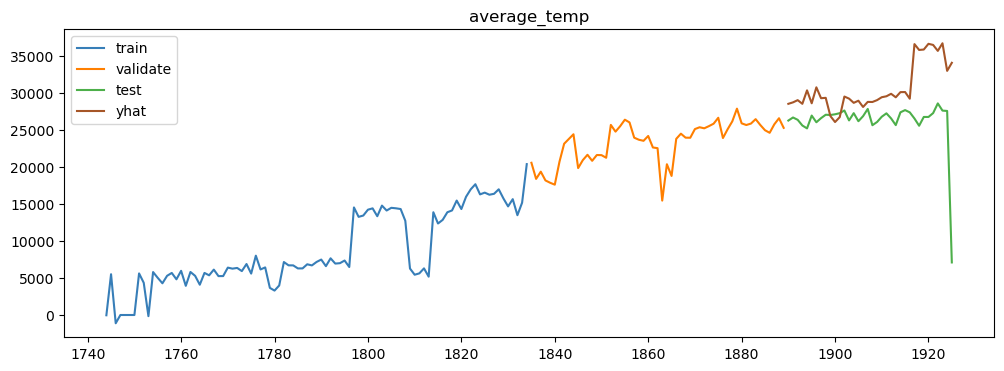

In [152]:
print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-average_temp: ', rmse_average_temp)
for col in train.columns:
    final_plot(col)

In [175]:
forecast = pd.DataFrame({'average_temp': hst_temp_fit1.forecast(validate.shape[0] + test.shape[0] + 100),
                        })
forecast = forecast['1925':]
forecast

,average_temp
1925-12-31,33696.544161
1926-12-31,34314.496887
1927-12-31,33384.310797
1928-12-31,32770.379669
1929-12-31,34133.903890
1930-12-31,34331.783930
1931-12-31,34629.429239
1932-12-31,34136.350636
1933-12-31,35951.031735
1934-12-31,34205.517131


In [176]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

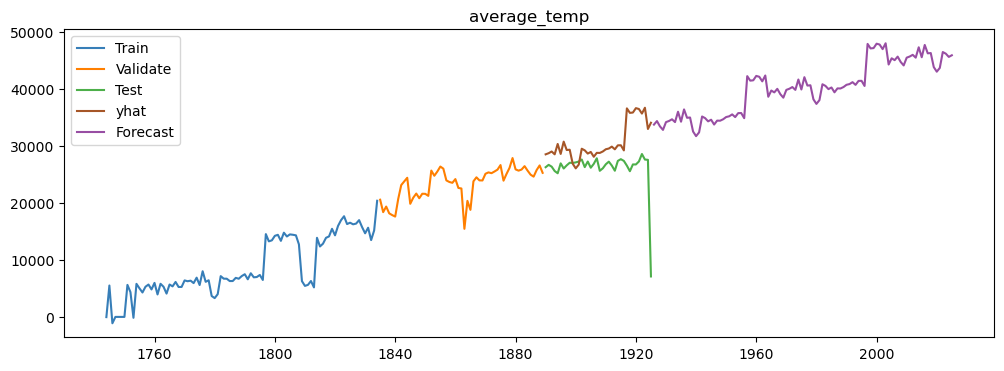

In [177]:
for col in train.columns:
    final_plot(col)